In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('/content/credit_train_processed.csv')
data.head()

,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Annual_Income,Years_in_current_job,Home_Ownership,Purpose,Monthly_Debt,Years_of_Credit_History,...,Number_of_Credit_Problems,Current_Credit_Balance,Credit_Limit,Bankruptcies,Tax_Liens,DTI,Credit_Utilization,Years_since_last_delinquent,Avg_Account_Age,Annual_Debt
0,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,...,1,228190,416746.0,1.0,0.0,0.004467,0.547552,0.000000,2.866667,62576.88
1,Fully Paid,262328,Short Term,724.0,1174162.0,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,...,0,229976,850784.0,0.0,0.0,0.014083,0.270311,0.666667,0.602857,399551.76
2,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,...,1,297996,750090.0,0.0,0.0,0.013083,0.397280,2.416667,0.827778,350406.36
3,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,...,0,256329,386958.0,0.0,0.0,0.010833,0.662421,0.000000,1.333333,104902.80
4,Fully Paid,176220,Short Term,724.0,1174162.0,5 years,Rent,Debt Consolidation,20639.70,6.1,...,0,253460,427174.0,0.0,0.0,0.014083,0.593341,0.000000,0.406667,247676.40


In [3]:
#Converting categorical data to binary data
lb = LabelEncoder()
data['Loan_Status'] = lb.fit_transform(data['Loan_Status'])
data['Term'] = lb.fit_transform(data['Term'])
data['Years_in_current_job'] = lb.fit_transform(data['Years_in_current_job'])
data['Home_Ownership'] = lb.fit_transform(data['Home_Ownership'])
data['Purpose'] = lb.fit_transform(data['Purpose'])


In [4]:
data["Loan_Status"].unique
a = data["Loan_Status"].value_counts()
print(a)
colnames = list(data.columns.values)

Loan_Status
1    77361
0    22639
Name: count, dtype: int64


# **Separating the target and predictor coloumn**

In [5]:
column_number = data.columns.get_loc('Annual_Debt')
print(f"The column number of Loan_Status is: {column_number}")

The column number of Loan_Status is: 21


In [6]:
predictors = colnames[1:22]
target = colnames[0]
predictors

['Current_Loan_Amount',
 'Term',
 'Credit_Score',
 'Annual_Income',
 'Years_in_current_job',
 'Home_Ownership',
 'Purpose',
 'Monthly_Debt',
 'Years_of_Credit_History',
 'Months_since_last_delinquent',
 'Number_of_Open_Accounts',
 'Number_of_Credit_Problems',
 'Current_Credit_Balance',
 'Credit_Limit',
 'Bankruptcies',
 'Tax_Liens',
 'DTI',
 'Credit_Utilization',
 'Years_since_last_delinquent',
 'Avg_Account_Age',
 'Annual_Debt']

In [7]:
target

'Loan_Status'

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.3)
print(train.shape)
print(test.shape)

(70000, 22)
(30000, 22)


In [9]:
# Replace infinite values with NaN
train[predictors] = train[predictors].replace([np.inf, -np.inf], np.nan)
test[predictors] = test[predictors].replace([np.inf, -np.inf], np.nan)


# Replace NaN values with mode for each predictor column
for column in predictors:
    mode_value = train[column].mode()[0]  # Get the mode value
    train[column] = train[column].fillna(mode_value)  # Replace NaN with mode in training set
    test[column] = test[column].fillna(mode_value)  # Replace NaN with mode in testing set

In [10]:
from sklearn.tree import DecisionTreeClassifier as DT

In [11]:
model = DT(criterion = 'entropy', max_depth=1)
model.fit(train[predictors],train[target])

DecisionTreeClassifier(criterion='entropy', max_depth=1)

[Text(0.5, 0.75, 'x[2] <= 3300.5\nentropy = 0.773\nsamples = 70000\nvalue = [15881.0, 54119.0]'),
 Text(0.25, 0.25, 'entropy = 0.701\nsamples = 66813\nvalue = [12694, 54119]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 3187\nvalue = [3187, 0]'),
 Text(0.625, 0.5, '  False')]

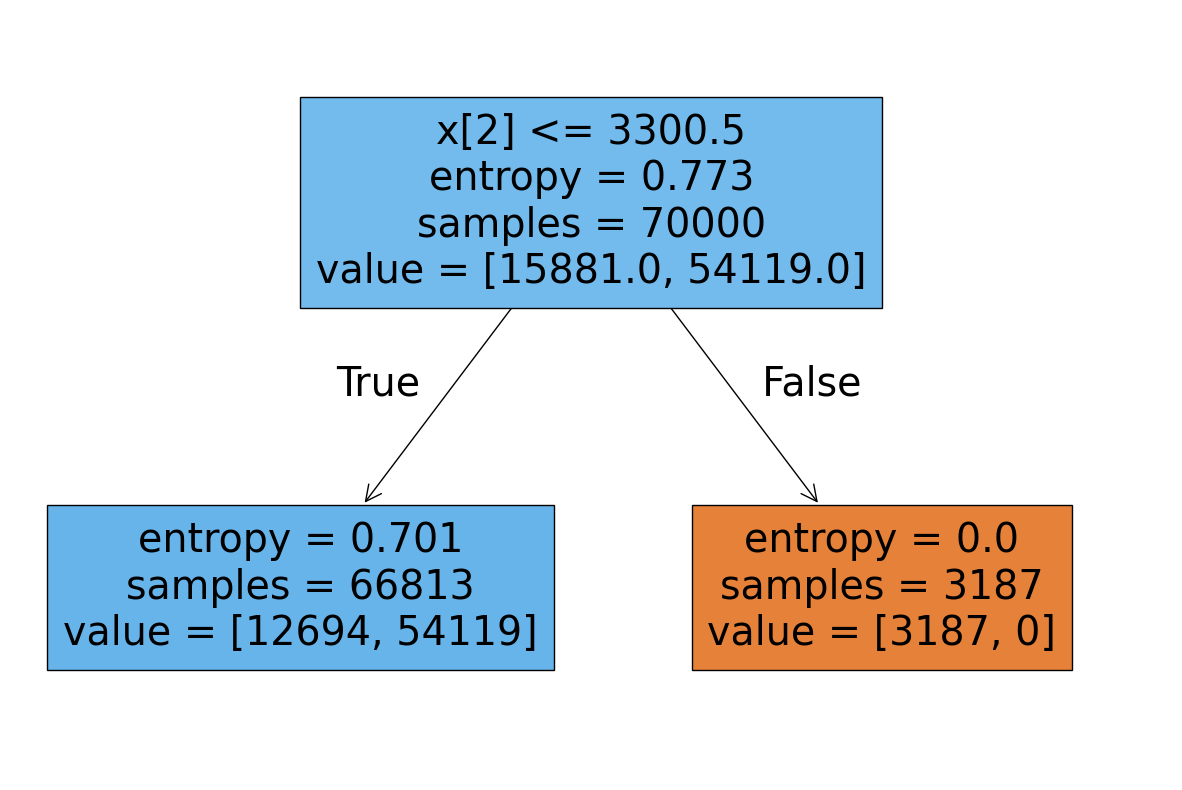

In [12]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model,filled=True)

In [13]:
preds = model.predict(test[predictors])
pd.crosstab(test[target],preds,rownames=['Actual'],colnames=['Predictions'])

Predictions,0,1
Actual,,
0,1364,5394
1,0,23242


# **Tested data accuracy**

In [14]:
np.mean(preds==test[target])

0.8202

# **Train data accuracy**

In [15]:
preds = model.predict(train[predictors])
pd.crosstab(train[target],preds,rownames=['Actual'],colnames=['Predictions'])
np.mean(preds==train[target])

0.8186571428571429

# **Hyper parameter training to adjust the best possible "max_depth" value**

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameter grid
param_grid = {'max_depth': range(1, 11)}  # Explore max_depth from 1 to 10

# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy')

# Create GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your training data
grid_search.fit(train[predictors], train[target])

# Get the best max_depth value
best_max_depth = grid_search.best_params_['max_depth']

print(f"Best max_depth: {best_max_depth}")

Best max_depth: 1


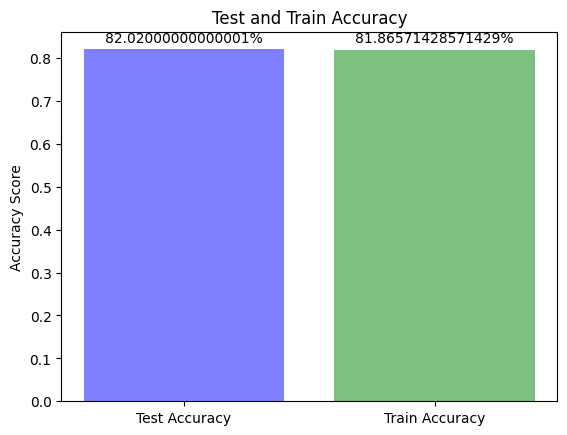

In [20]:
test_accuracy = 0.8202
train_accuracy = 0.8186571428571429
test_accuracy_percentage = "{:.10f}%".format(test_accuracy * 100)
train_accuracy_percentage = "{:.10f}%".format(train_accuracy * 100)


# Create a bar graph
accuracy_scores = [test_accuracy, train_accuracy]
labels = ['Test Accuracy', 'Train Accuracy']
x_pos = np.arange(len(labels))

plt.bar(x_pos, accuracy_scores, align='center', alpha=0.5,color=['blue', 'green'])
plt.xticks(x_pos, labels)
plt.ylabel('Accuracy Score')
plt.title('Test and Train Accuracy')

# Add the percentage values on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(x_pos[i], score + 0.01, str(score *100)+'%', ha='center', va='bottom')

plt.show()